# 06. Random Forest regression
__Capstone project: Duration of the insertion of real estate advertisements for rental apartments in Switzerland__

The basic idea behind a random forest model is to combine multiple Decision Trees in determining the final output by taking the average of the individual trees. This averaging makes a Random Forest better than Decision Tree, as it improves accuracy and reduces overfitting. Random Forest is a Bagging technique (Bootstrap Aggregation), meaning that random sub-samples of the training set is taked with replacement. The model is then trained on each sample. 

I choose this model because it works well for large data, normally achieves high accuracies and is easy interpretable. A disadvantage of Random Forest models is, that they can not extrapolate based on the data, meaning the predictions always are in the range of the training set. The Random Forest model creates its predictions by averaging and can thus not go beyond what it has been exposed to in training - unlike a linear model. I believe, for my data extrapolation is not crucial.

The random forest model will use the built-in "feature importance" algorithm to select the most informative features. At each interal node, the feature with highest variance decrease is selected.
 
For the random forest model I will use RandomizedSearchCV to determine the best number of trees, maximum number of levels in tree and other parameters. Random Forest randomizes the feature selection during each tree split, that why I believe Cross Validation is not needed in addition. Also because it would make the calculation very long.


## Import

In [1]:
# import commands
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("Data/df_after_eda.csv", delimiter=",")

In [3]:
df.shape

(921886, 142)

## Split data

First I will load the features into a feature matrix X and the target value into an output vector y. 

In [4]:
X = df.drop("Insertionsdauer", axis=1).values
y = df["Insertionsdauer"].values

I decided to split my data 80% - 20%, because I have a lot of data points and the proportion of testing data should be enough. Furthermore I chose the number 8 for the the random_state, as it is my lucky number.

In [5]:
from sklearn.model_selection import train_test_split

X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2, random_state=8)

In [6]:
print("Shape X_tr:", X_tr.shape)
print("Shape y_tr:", y_tr.shape)

Shape X_tr: (737508, 141)
Shape y_tr: (737508,)


In [7]:
print("For my training data, the dimensionality is {:}".format(X_tr.shape[1]),"and the cardinality is {:}.".format(X_tr.shape[0]),)

For my training data, the dimensionality is 141 and the cardinality is 737508.


## Downsampling training data 

Since my dataframe is very big, the calculation for the hyperparametertuning incl. CV and GridSearch takes a lot of time. Therefore I decided to downsample my training and validation data to something more manageable, yet representative, in order to identify suitable hyperparameters or a least the best range for the hyperparameters. I will use sklearn's resample method and keep 30'000 samples. I am not consernd about inbalanced categorical data, as my target is a numerical. Otherwise, I could use the arugment ``stratify`` to preserve the distribution in the original classes of a selected categorical feature. 

In [8]:
from sklearn.utils import resample
X_tr_sample = resample(X_tr, random_state=8, n_samples=30000, replace=False)
X_tr_sample.shape

(30000, 141)

In [9]:
y_tr_sample = resample(y_tr, random_state=8, n_samples=30000, replace=False)
y_tr_sample.shape

(30000,)

## Random Forest

* __n_estimators__: number of trees in the random forest. The higher the number of trees, the better to learn the data. But a high number of trees will slow down the training process, therefore I have to find the sweet spot.
    
* __max_depth__: maximum number of levels in tree. The deeper the tree, the more splits at each decision tree. If the number of splits is too low, the model underfits the data and if it is too high the model overfits.

* __max_features__: number of features to consider at every split. The specific features that are passed to each decision tree can vary between each decision tree.

* __min_sample_split__: minimum number of samples required to split a node (=subest). By increasing this parameter, each tree becomes more constrained as it has to consider more samples. 
    
* __min_sample_leaf__: minimum number of samples required at each leaf node. It is similar to min_samples_splits, but it describe the minimum number of samples at the leafs, thus the base of the tree.

The complexity of the model increases with higher n_estimators and max_features.

### Random search for optimal parameters

__RandomizedSearchCV:__ Grid Search tries all possible combinations of the hyperparameters and finds the best ones. If there are many hyperparameters to be tuned, it can be computationally expensive. Therefore I will use RandomizedSearchCV instead of GridSearchCV. RandomizedSearchCV tries random combinations of a range of values. The number of iteration ``n_iter`` determines how many runs in total the randomized search will try, before concluding the search. A n_iter of 10, means the model will be fit 10 different combination of parameter distributions. RandomizedSearchCV can get good cominations faster, but does not guarantee the best parameter combination because not all combinations are tried out.  

In [24]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from matplotlib import pyplot

In [11]:
# Create pipeline
pipe = Pipeline(steps=[("rfr", RandomForestRegressor())])

In [29]:
# Create the grid
grid_RS = {'rfr__n_estimators': [2, 10, 50, 100, 250, 500, 750, 1000],# Number of trees in random forest
           'rfr__max_features': ['auto', 'sqrt'], # Number of features to consider at every split
           'rfr__max_depth': [5, 8, 12], # Maximum number of levels in tree
           'rfr__min_samples_split': [2, 5, 8], # Minimum number of samples required to split a node
           'rfr__min_samples_leaf': [1, 2, 4]} # Minimum number of samples required at each leaf node

# Search of parameters with RandomizedSearchCV
rf_RS = RandomizedSearchCV(estimator=pipe, param_distributions=grid_RS,
                           return_train_score=True, scoring='neg_mean_absolute_error', 
                           verbose=1, n_jobs=-1, n_iter = 50, random_state=8)

# Fit estimator
rf_RS.fit(X_tr_sample, y_tr_sample)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(estimator=Pipeline(steps=[('rfr', RandomForestRegressor())]),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'rfr__max_depth': [5, 8, 12],
                                        'rfr__max_features': ['auto', 'sqrt'],
                                        'rfr__min_samples_leaf': [1, 2, 4],
                                        'rfr__min_samples_split': [2, 5, 8],
                                        'rfr__n_estimators': [2, 10, 50, 100,
                                                              250, 500, 750,
                                                              1000]},
                   random_state=8, return_train_score=True,
                   scoring='neg_mean_absolute_error', verbose=1)

In [30]:
# Visualize the results in a DataFrame
rf_RS_results = pd.DataFrame(rf_RS.cv_results_)

# Select a few interesting columns
cols = [
    "mean_test_score",
    "std_test_score",
    "mean_train_score",
    "std_train_score",
    "rank_test_score",
    'param_rfr__n_estimators',
    'param_rfr__max_features',
    'param_rfr__max_depth',
    'param_rfr__min_samples_split',
    'param_rfr__min_samples_leaf']

# show results
rf_RS_results[cols].sort_values("mean_test_score", ascending=False).round(4).T

,3,31,35,22,0,36,23,16,27,40,...,15,29,34,42,39,41,28,8,26,47
mean_test_score,-0.8535,-0.8536,-0.8539,-0.8542,-0.8558,-0.8567,-0.8568,-0.8568,-0.8569,-0.857,...,-0.8747,-0.8759,-0.876,-0.8761,-0.8761,-0.8762,-0.8765,-0.8912,-0.9026,-0.9092
std_test_score,0.0103,0.0107,0.0104,0.0102,0.0105,0.0103,0.0102,0.0102,0.0103,0.0101,...,0.0134,0.01,0.0099,0.0099,0.0101,0.0097,0.0102,0.0094,0.0115,0.0123
mean_train_score,-0.7163,-0.7052,-0.7164,-0.7047,-0.7157,-0.8143,-0.8136,-0.8145,-0.814,-0.8137,...,-0.831,-0.8719,-0.8721,-0.8719,-0.8721,-0.872,-0.8294,-0.8127,-0.7675,-0.7505
std_train_score,0.002,0.0021,0.002,0.0018,0.0014,0.0022,0.0024,0.0024,0.0023,0.0023,...,0.0025,0.0025,0.0025,0.0026,0.0025,0.0026,0.0024,0.0052,0.0027,0.0016
rank_test_score,1,2,3,4,5,6,7,8,9,10,...,41,42,43,44,45,46,47,48,49,50
param_rfr__n_estimators,750,500,250,250,50,500,1000,500,750,750,...,2,1000,500,750,750,100,2,2,2,2
param_rfr__max_features,auto,auto,auto,auto,auto,auto,auto,auto,auto,auto,...,auto,sqrt,sqrt,sqrt,sqrt,sqrt,auto,sqrt,auto,auto
param_rfr__max_depth,12,12,12,12,12,8,8,8,8,8,...,8,5,5,5,5,5,8,12,12,12
param_rfr__min_samples_split,5,5,5,5,8,2,2,8,5,5,...,5,2,8,2,2,5,2,2,8,2
param_rfr__min_samples_leaf,4,2,4,2,1,4,1,4,1,2,...,2,4,4,1,4,2,2,2,4,2


In [31]:
rf_RS.best_params_

{'rfr__n_estimators': 750,
 'rfr__min_samples_split': 5,
 'rfr__min_samples_leaf': 4,
 'rfr__max_features': 'auto',
 'rfr__max_depth': 12}

In [32]:
rf_RS.best_score_

-0.8534529303811166

#### Visualise scores

Best value for n_estimators: 750


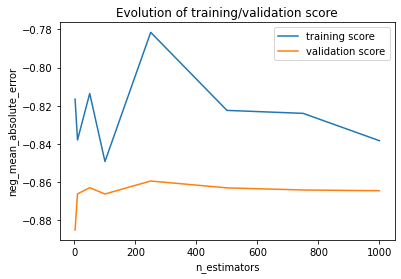

In [33]:
# show best value
print("Best value for n_estimators: {:}".format(rf_RS.best_params_['rfr__n_estimators']))

# calculate mean groubed by parameter
mean_estimators = rf_RS_results.groupby(['param_rfr__n_estimators']).mean()

# plot
plt.plot(list(mean_estimators.index),mean_estimators['mean_train_score'], label='training score')
plt.plot(list(mean_estimators.index),mean_estimators['mean_test_score'], label='validation score')

# labels & title
plt.ylabel("neg_mean_absolute_error")
plt.xlabel("n_estimators")
plt.title("Evolution of training/validation score")
plt.legend()
plt.show()

Best value for max_depth: 12


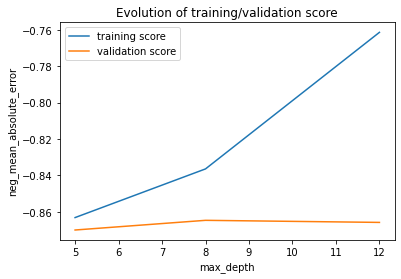

In [34]:
# show best value
print("Best value for max_depth: {:}".format(rf_RS.best_params_['rfr__max_depth']))

# calculate mean groubed by parameter
mean_estimators = rf_RS_results.groupby(['param_rfr__max_depth']).mean()

# plot
plt.plot(list(mean_estimators.index),mean_estimators['mean_train_score'], label='training score')
plt.plot(list(mean_estimators.index),mean_estimators['mean_test_score'], label='validation score')

# labels & title
plt.ylabel("neg_mean_absolute_error")
plt.xlabel("max_depth")
plt.title("Evolution of training/validation score")
plt.legend()
plt.show()

Best value for min_samples_split: 5


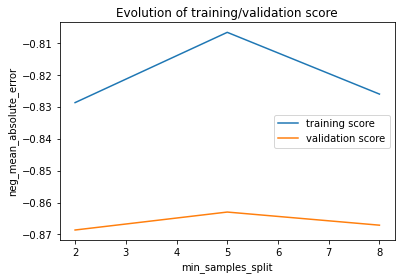

In [35]:
# show best value
print("Best value for min_samples_split: {:}".format(rf_RS.best_params_['rfr__min_samples_split']))

# calculate mean groubed by parameter
mean_estimators = rf_RS_results.groupby(['param_rfr__min_samples_split']).mean()

# plot
plt.plot(list(mean_estimators.index),mean_estimators['mean_train_score'], label='training score')
plt.plot(list(mean_estimators.index),mean_estimators['mean_test_score'], label='validation score')

# labels & title
plt.ylabel("neg_mean_absolute_error")
plt.xlabel("min_samples_split")
plt.title("Evolution of training/validation score")
plt.legend()
plt.show()

Best value for max_features: auto


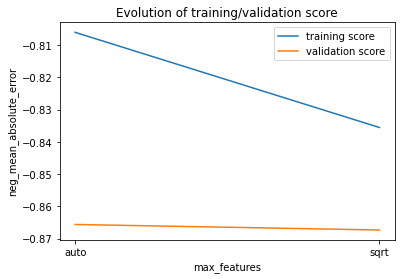

In [36]:
# show best value
print("Best value for max_features: {:}".format(rf_RS.best_params_['rfr__max_features']))

# calculate mean groubed by parameter
mean_estimators = rf_RS_results.groupby(['param_rfr__max_features']).mean()

# plot
plt.plot(list(mean_estimators.index),mean_estimators['mean_train_score'], label='training score')
plt.plot(list(mean_estimators.index),mean_estimators['mean_test_score'], label='validation score')

# labels & title
plt.ylabel("neg_mean_absolute_error")
plt.xlabel("max_features")
plt.title("Evolution of training/validation score")
plt.legend()
plt.show()

Best value for min_samples_leaf: 4


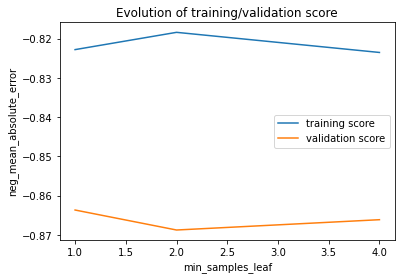

In [37]:
# show best value
print("Best value for min_samples_leaf: {:}".format(rf_RS.best_params_['rfr__min_samples_leaf']))

# calculate mean groubed by parameter
mean_estimators = rf_RS_results.groupby(['param_rfr__min_samples_leaf']).mean()

# plot
plt.plot(list(mean_estimators.index),mean_estimators['mean_train_score'], label='training score')
plt.plot(list(mean_estimators.index),mean_estimators['mean_test_score'], label='validation score')

# labels & title
plt.ylabel("neg_mean_absolute_error")
plt.xlabel("min_samples_leaf")
plt.title("Evolution of training/validation score")
plt.legend()
plt.show()

As the table of the scores and the plots above makes it difficult to interpret the results for the different combinations of parameters, I will visualize them on a 3D plot. I will only concentrate on ``n_estimators``, ``max_depth`` and ``min_sample_split`` as the other two parameters seem to be easier to interpret or do not change that much.

In [38]:
# Source: https://towardsdatascience.com/using-3d-visualizations-to-tune-hyperparameters-of-ml-models-with-python-ba2885eab2e9

text_list = list(
    zip(
        'n_estimators: ' + rf_RS_results['param_rfr__n_estimators'].apply(str)+ '<br>',
        'min_sample_split: ' + rf_RS_results['param_rfr__min_samples_split'].apply(str)+ '<br>',
        'max_depth: ' + rf_RS_results['param_rfr__max_depth'].apply(str)+ '<br>',
        'min_samples_leaf: ' + rf_RS_results['param_rfr__min_samples_leaf'].apply(str)+ '<br>',
        'max_features: ' + rf_RS_results['param_rfr__max_features'].apply(str)+ '<br>',
        'Test score: ' + rf_RS_results.mean_test_score.round(4).apply(str)+ '<br>',
        'Train score: ' + rf_RS_results.mean_train_score.round(4).apply(str)+ '<br>',
    )
)

text = [''.join(t) for t in text_list]

In [39]:
rf_RS_results['Text'] = text

In [89]:
# Source: https://towardsdatascience.com/using-3d-visualizations-to-tune-hyperparameters-of-ml-models-with-python-ba2885eab2e9

# Import modules to work with data visualizations offline
from plotly.offline import iplot
import plotly.graph_objs as go
from ipywidgets import interactive, HBox, VBox, widgets, interact

# Define axis
x=rf_RS_results['param_rfr__n_estimators']
y=rf_RS_results['param_rfr__min_samples_split']
z=rf_RS_results['param_rfr__max_depth']

# scatter plot
trace = go.Scatter3d(
    x=x,
    y=y,
    z=z,
    mode='markers', 
    marker=dict(
        #size=rf_RS_results.mean_fit_time ** (1 / 3) * 1,
        color=rf_RS_results.mean_train_score,
        opacity=0.99,
        colorscale='Viridis',
        colorbar=dict(title = 'Train score'),
        line=dict(color='rgb(140, 140, 170)')
    ),
    text=rf_RS_results.Text,
    hoverinfo='text'
)



data = [trace]
layout = go.Layout(
    margin=dict(
        l=20,
        r=20,
        b=20,
        t=20
    ),
#     height=600,
#     width=960,
    scene = dict(
        xaxis = dict(
            title='n_estimators',
            range=[x.min(), x.max()]
        ),
        yaxis = dict(
            title='min_sample_split',
        ),
        zaxis = dict(
            title='max_depth',

        ),
    ),
)
fig = go.Figure(data=data, layout=layout)

# add slider
f = go.FigureWidget(data=data, layout=layout)


xmin, xmax = f['layout']['scene']['xaxis']['range']


slider = widgets.FloatRangeSlider(
    value=f.layout.scene.xaxis.range,
    min=xmin,
    max=xmax,
    step=(xmax - xmin) / 100.0,
#     readout=False,
    description='n_estimators')
slider.layout.width = '600px'

def update_range(y):
    f.layout.scene.xaxis.range = [y[0], y[1]]
    
    
# display the FigureWidget and slider with center justification
vb = VBox((interactive(update_range, y=slider), f, ))
vb.layout.align_items = 'center'
vb

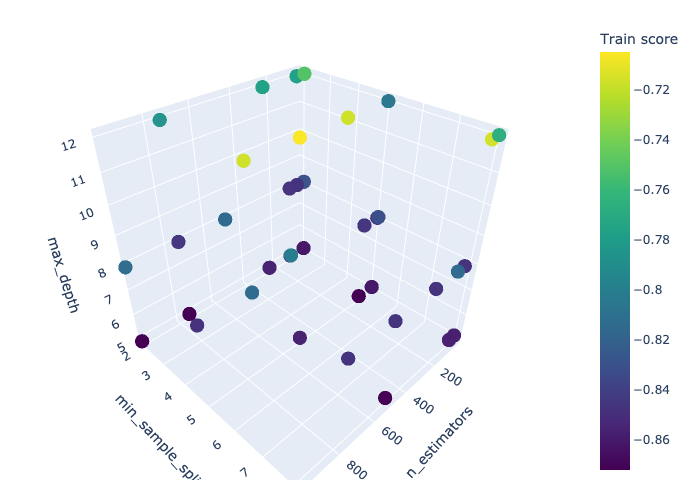

In [92]:
# static image display for github 
from IPython.display import Image

img_bytes = fig.to_image(format="png")
Image(img_bytes)

In [1]:
# Source: https://towardsdatascience.com/using-3d-visualizations-to-tune-hyperparameters-of-ml-models-with-python-ba2885eab2e9

# Import modules to work with data visualizations offline
from plotly.offline import iplot
import plotly.graph_objs as go
from ipywidgets import interactive, HBox, VBox, widgets, interact

# Define axis
x=rf_RS_results['param_rfr__n_estimators']
y=rf_RS_results['param_rfr__min_samples_split']
z=rf_RS_results['param_rfr__max_depth']

# scatter plot
trace = go.Scatter3d(
    x=x,
    y=y,
    z=z,
    mode='markers', 
    marker=dict(
        #size=rf_RS_results.mean_fit_time ** (1 / 3) * 1,
        color=rf_RS_results.mean_test_score,
        opacity=0.99,
        colorscale='Viridis',
        colorbar=dict(title = 'Test score'),
        line=dict(color='rgb(140, 140, 170)')
    ),
    text=rf_RS_results.Text,
    hoverinfo='text'
)



data = [trace]
layout = go.Layout(
    margin=dict(
        l=20,
        r=20,
        b=20,
        t=20
    ),
#     height=600,
#     width=960,
    scene = dict(
        xaxis = dict(
            title='n_estimators',
            range=[x.min(), x.max()]
        ),
        yaxis = dict(
            title='min_sample_split',
        ),
        zaxis = dict(
            title='max_depth',

        ),
    ),
)
fig = go.Figure(data=data, layout=layout)


# add slider
f = go.FigureWidget(data=data, layout=layout)


xmin, xmax = f['layout']['scene']['xaxis']['range']


slider = widgets.FloatRangeSlider(
    value=f.layout.scene.xaxis.range,
    min=xmin,
    max=xmax,
    step=(xmax - xmin) / 100.0,
#     readout=False,
    description='n_estimators')
slider.layout.width = '600px'

def update_range(y):
    f.layout.scene.xaxis.range = [y[0], y[1]]
    
    
# display the FigureWidget and slider with center justification
vb = VBox((interactive(update_range, y=slider), f, ))
vb.layout.align_items = 'center'
vb

NameError: name 'rf_RS_results' is not defined

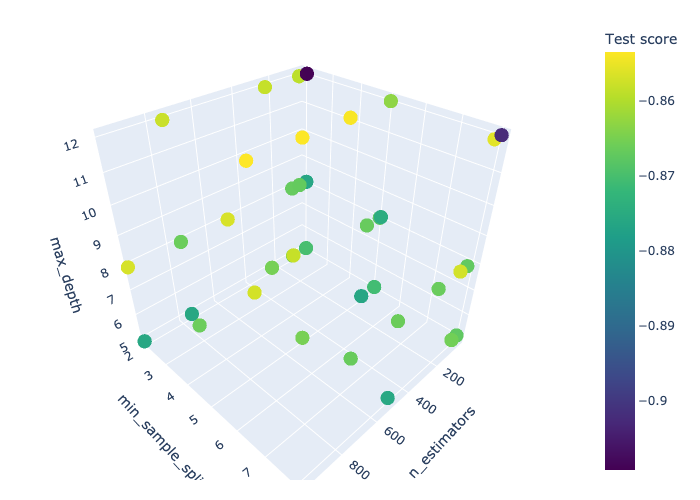

In [94]:
# static image display for github 
img_bytes = fig.to_image(format="png")
Image(img_bytes)

My model shows signs of overfitting, it makes good predictions on the data it was trained on, but is not able to generalize well. In general, Random Forest models are much less likely to overfit than other models such as Decision Trees thanks to bagging and random feature selection. Random Forest models consist of many regressions trained completely independently on completely different subsets of the training data. But there still can be overfitting. 

If we add more trees to the Random Forest, the prediction variance will decrease, improving the accuracy of the ensemble. Thus the tendency to overfitt will decrease. However, the bias of the generalization will not. To avoid overfitting, the hyper-parameters such as the depth should be reduced. Therefore in a next step, I will define a model with a high number of trees but a rather low maximum depth.

### Grid search for finetuning the parameters 

For finetuning the parameters I will use GridSearchCV and again only the sample data. I only finetune the number of trees.

In [53]:
# Create the grid
grid_GS = {
    'rfr__n_estimators': [850, 800, 750, 700, 650], # Number of trees in random forest
    'rfr__max_features': ['auto'], # Number of features to consider at every split
    'rfr__max_depth': [8], # Maximum number of levels in tree
    'rfr__min_samples_split': [5], # Minimum number of samples required to split a node
    'rfr__min_samples_leaf': [4] # Minimum number of samples required at each leaf node
}

# Search of parameters with GridSearchCV
rf_GS = GridSearchCV(pipe, grid_GS, return_train_score=True, 
                     scoring='neg_mean_absolute_error',verbose=1, n_jobs = -1)

# Fit estimator
rf_GS.fit(X_tr_sample, y_tr_sample)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


GridSearchCV(estimator=Pipeline(steps=[('rfr', RandomForestRegressor())]),
             n_jobs=-1,
             param_grid={'rfr__max_depth': [8], 'rfr__max_features': ['auto'],
                         'rfr__min_samples_leaf': [4],
                         'rfr__min_samples_split': [5],
                         'rfr__n_estimators': [850, 800, 750, 700, 650]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [54]:
rf_GS.best_params_

{'rfr__max_depth': 8,
 'rfr__max_features': 'auto',
 'rfr__min_samples_leaf': 4,
 'rfr__min_samples_split': 5,
 'rfr__n_estimators': 700}

In [57]:
rf_GS.best_score_

-0.8567421275519693

#### Visualise scores

In [55]:
# Visualize the results in a DataFrame
rf_GS_results = pd.DataFrame(rf_GS.cv_results_)

# Select a few interesting columns
cols = [
    "mean_test_score",
    "std_test_score",
    "mean_train_score",
    "std_train_score",
    "rank_test_score",
    'param_rfr__n_estimators',
    'param_rfr__max_features',
    'param_rfr__max_depth',
    'param_rfr__min_samples_split',
    'param_rfr__min_samples_leaf']

# show results
rf_GS_results[cols].sort_values("mean_test_score", ascending=False).round(4).T

,3,1,4,0,2
mean_test_score,-0.8567,-0.8567,-0.8568,-0.8568,-0.8569
std_test_score,0.0101,0.0102,0.0103,0.0102,0.0102
mean_train_score,-0.8143,-0.8144,-0.8143,-0.8145,-0.8144
std_train_score,0.0024,0.0024,0.0023,0.0022,0.0023
rank_test_score,1,2,3,4,5
param_rfr__n_estimators,700,800,650,850,750
param_rfr__max_features,auto,auto,auto,auto,auto
param_rfr__max_depth,8,8,8,8,8
param_rfr__min_samples_split,5,5,5,5,5
param_rfr__min_samples_leaf,4,4,4,4,4


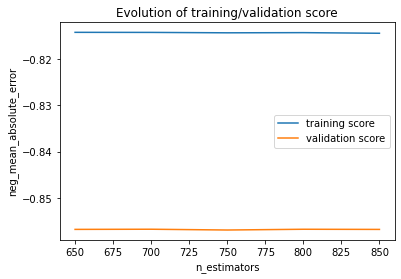

In [56]:
# calculate mean groubed by parameter
mean_estimators = rf_GS_results.groupby(['param_rfr__n_estimators']).mean()

# plot
plt.plot(list(mean_estimators.index),mean_estimators['mean_train_score'], label='training score')
plt.plot(list(mean_estimators.index),mean_estimators['mean_test_score'], label='validation score')

# labels & title
plt.ylabel("neg_mean_absolute_error")
plt.xlabel("n_estimators")
plt.title("Evolution of training/validation score")
plt.legend()
plt.show()

The evolution of the training and validation curves show, that no matter if the number of trees is 650 oder 850, it does not change the MAE value. We can also see that the validation score is close to the training score, meaning that the estimator is not overfitting anymore. 

### Random Forest regression with the whole training data

In [68]:
# Modify best estimator
rf_final=rf_GS.best_estimator_
rf_final.set_params(rfr__n_jobs=-1)

# Fit RandomForest regression
rf_final.fit(X_tr, y_tr)

Pipeline(steps=[('rfr',
                 RandomForestRegressor(max_depth=8, min_samples_leaf=4,
                                       min_samples_split=5, n_estimators=700,
                                       n_jobs=-1))])

## Evaluation and predictions

In [60]:
# make prediction on test set
y_pred_te = rf_final.predict(X_te)
y_pred_tr = rf_final.predict(X_tr)

In [61]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from math import sqrt

# calculate mae, mse, rmse and R2 for train data
print('Train set evaluation:\n_____________________________________')
print("MAE: {:.3f}".format(mean_absolute_error(y_tr, y_pred_tr)))
print("MSE: {:.3f}".format(mean_squared_error(y_tr, y_pred_tr)))
print("RMSE: {:.3f}".format(sqrt((mean_squared_error(y_tr, y_pred_tr)))))
print("R2: {:.3f}".format(rf_final.score(X_tr, y_tr)))

# calculate mae, mse, rmse and R2 for test data
print('\nTest set evaluation:\n_____________________________________')
print("MAE: {:.3f}".format(mean_absolute_error(y_te, y_pred_te)))
print("MSE: {:.3f}".format(mean_squared_error(y_te, y_pred_te)))
print("RMSE: {:.3f}".format(sqrt(mean_squared_error(y_te, y_pred_te))))
print("R2: {:.3f}".format(rf_final.score(X_te, y_te)))


Train set evaluation:
_____________________________________
MAE: 0.852
MSE: 1.092
RMSE: 1.045
R2: 0.116

Test set evaluation:
_____________________________________
MAE: 0.852
MSE: 1.093
RMSE: 1.046
R2: 0.114


## Feature importance

Feature importance explains which features are more important in training of model. Let's have a look at the top important features.

In [62]:
rf_final.named_steps

{'rfr': RandomForestRegressor(max_depth=8, min_samples_leaf=4, min_samples_split=5,
                       n_estimators=700, n_jobs=-1)}

In [63]:
# get the feature importance and feature names
importance = rf_final.named_steps["rfr"].feature_importances_
feat_labels = df.drop('Insertionsdauer', axis=1).columns

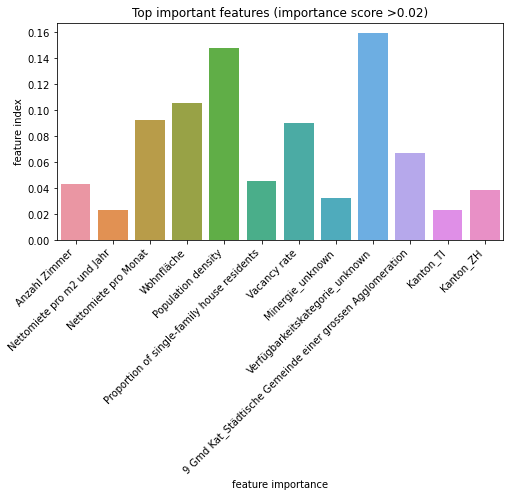

In [64]:
# plot of the most importance features

#Define size of bar plot
plt.figure(figsize=(8,4))

#Plot Searborn bar chart with importance score above 0.02
sns.barplot(x=np.array(feat_labels)[importance > 0.02], y=importance[importance > 0.02])

#Add chart labels
plt.title('Top important features (importance score >0.02)')
plt.xlabel('feature importance')
plt.xticks(rotation=45, ha="right")
plt.ylabel('feature index')

plt.show()

These are the features with the best predictive power. Interesstingly, the most important features are predominantly numeric features, only the ``Verfügbarkeitskategorie`` (category of aviability) and the ``9 Gmd Kat...`` (9 spatial category) are a one-hot encoded categorical features. 

---

## Export

In [65]:
# Export model predictions
predictions = pd.DataFrame({'Model': 'random forest',
                            'True Value': np.exp(y_te),
                            'Prediction': np.exp(y_pred_te),
                           'Error': np.exp(y_te) - np.exp(y_pred_te)})

predictions.to_csv("ML_predictions_rf.csv", encoding='utf-8', index=False)

In [66]:
# Export model predictions
predictions = pd.DataFrame({'Model': 'random forest',
                            'True Value': np.exp(y_tr),
                            'Prediction': np.exp(y_pred_tr),
                           'Error': np.exp(y_tr) - np.exp(y_pred_tr)})

predictions.to_csv("ML_predictions_rf_train.csv", encoding='utf-8', index=False)

In [67]:
# Export model evaluation
# Source: https://www.geeksforgeeks.org/how-to-append-a-new-row-to-an-existing-csv-file/

# Import writer class from csv module
from csv import writer
 
# List that we want to add as a new row
List = ['Random Forest', mean_absolute_error(y_te, y_pred_te), mean_squared_error(y_te, y_pred_te),
                          sqrt((mean_squared_error(y_te,y_pred_te))), rf_final.score(X_te, y_te)]
 
# Open our existing CSV file in append mode
# Create a file object for this file
with open('ML_evaluations.csv', 'a') as f_object:
 
    # Pass this file object to csv.writer()
    # and get a writer object
    writer_object = writer(f_object)
 
    # Pass the list as an argument into
    # the writerow()
    writer_object.writerow(List)
 
    # Close the file object
    f_object.close()